In [1]:
from src.geojson import build_geojson_feature_collection
import numpy as np
from src.cluster_stats import Stats
from src.darwin_core_aggregations import DarwinCoreAggregations
from src.render import plot_clusters
from src.geojson import build_geojson_feature_collection
import logging
from run import cluster
from src import cluster_index
import polars as pl


In [2]:
# Inputs
input_file = "data-new-york-city.txt"
geohash_precision = 6
show_dendrogram = True
log_file = "log.txt"
output_file = "output.geojson"
num_clusters = 8
use_cache = False
plot = True

In [3]:
# set up logging
logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [4]:
darwin_core_aggregations = DarwinCoreAggregations.build(
    input_file, geohash_precision
)

In [5]:
darwin_core_aggregations.unfiltered_taxon_counts

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""dr5nqk""","""Animalia""","""genus""","""Disholcaspis""",2
"""dr5nqk""","""Animalia""","""genus""","""Hylocichla""",2
"""dr5nqk""","""Animalia""","""species""","""Haplotrema concavum""",1
"""dr5nqk""","""Animalia""","""species""","""Geothlypis trichas""",2
"""dr5nqk""","""Animalia""","""species""","""Crassostrea virginica""",2
…,…,…,…,…
"""dr7891""","""Animalia""","""family""","""Limulidae""",1
"""dr7891""","""Animalia""","""species""","""Mergus serrator""",1
"""dr7891""","""Animalia""","""genus""","""Limulus""",1


In [6]:
darwin_core_aggregations.taxon_counts

geohash,kingdom,species,count
str,enum,str,u32
"""dr5nqk""","""Animalia""","""Haplotrema concavum""",1
"""dr5nqk""","""Animalia""","""Geothlypis trichas""",2
"""dr5nqk""","""Animalia""","""Crassostrea virginica""",2
"""dr5nqk""","""Animalia""","""Spilosoma virginica""",1
"""dr5nqk""","""Animalia""","""Passerina cyanea""",6
…,…,…,…
"""dr7890""","""Plantae""","""Linaria vulgaris""",1
"""dr7890""","""Animalia""","""Larus delawarensis""",1
"""dr7890""","""Fungi""","""Ganoderma resinaceum""",1


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


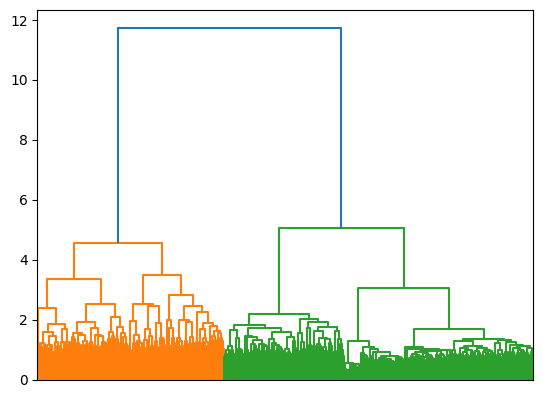

In [7]:

clusters = cluster.run(
    darwin_core_aggregations,
    num_clusters,
    show_dendrogram,
    use_cache,
)

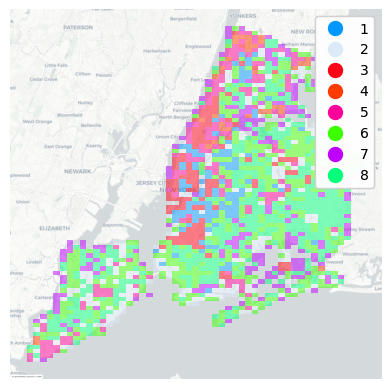

In [10]:
# Find the top averages of taxon
all_stats = Stats.build(darwin_core_aggregations)

feature_collection = build_geojson_feature_collection(
    (
        cluster,
        [i for i in geohashes if not i.startswith("z")],  # Exclude the Aleutian Islands
        cluster_index.determine_color_for_cluster(
            clusters, cluster, darwin_core_aggregations
        ),
    )
    for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters)
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

from run import write_geojson
write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [9]:
from run import print_cluster_stats
cluster_id = 1
geohashes = cluster_index.geohashes_for_cluster(clusters, cluster_id)
print_cluster_stats(cluster_id, geohashes, darwin_core_aggregations, all_stats)


ImportError: cannot import name 'print_cluster_stats' from 'run' (/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/run.py)

In [ ]:
stats_for_clusters = {
    cluster: Stats.build(
        darwin_core_aggregations,
        geohash_filter=geohashes,
    )
    for cluster, geohashes in cluster_index.iter_clusters_and_geohashes(clusters)
}
stats_for_clusters[2].taxon.filter(pl.col("species") == "Weigela florida").collect()


In [ ]:
[
    {
        "cluster": cluster,
        "waterfowl": stats.waterfowl_count(),
        "aves": stats.aves_count(),
        "ratio": stats.waterfowl_count() / stats.aves_count(),
    }
    for cluster, stats in stats_for_clusters.items()
]

